In [2]:
import sys
sys.path.append("/usr/local/cuda-12.6/nsight-compute-2024.3.0/extras/python")

import ncu_report as ncu

In [3]:
ncu_file_path = r"./reports/result_ncu_1.ncu-rep"

In [4]:
report_context = ncu.load_report(ncu_file_path)

In [5]:
report_range = report_context.range_by_idx(0)

report_range.num_actions()

action = report_range.action_by_idx(0)

action.metric_names()

# for name in action.metric_names():
#     val  = action.metric_by_name(name).value()

#     if isinstance(val, str):
#         continue

#     if val < 15 and val > 14:
#         print(f"{name} : {val}")

('breakdown:gpu__compute_memory_throughput.avg.pct_of_peak_sustained_elapsed',
 'breakdown:gpu__compute_memory_throughput.max.pct_of_peak_sustained_elapsed',
 'breakdown:gpu__compute_memory_throughput.min.pct_of_peak_sustained_elapsed',
 'breakdown:gpu__compute_memory_throughput.sum.pct_of_peak_sustained_elapsed',
 'breakdown:sm__throughput.avg.pct_of_peak_sustained_elapsed',
 'breakdown:sm__throughput.max.pct_of_peak_sustained_elapsed',
 'breakdown:sm__throughput.min.pct_of_peak_sustained_elapsed',
 'breakdown:sm__throughput.sum.pct_of_peak_sustained_elapsed',
 'c2clink__enabled_mask',
 'c2clink__present',
 'device__attribute_architecture',
 'device__attribute_async_engine_count',
 'device__attribute_can_flush_remote_writes',
 'device__attribute_can_map_host_memory',
 'device__attribute_can_tex2d_gather',
 'device__attribute_can_use_64_bit_stream_mem_ops',
 'device__attribute_can_use_64_bit_stream_mem_ops_v1',
 'device__attribute_can_use_host_pointer_for_registered_mem',
 'device__att

In [6]:
import pandas as pd

metrics_df = pd.DataFrame()

METRIC_MEMORY_THROUGHPUT_PERC = "gpu__compute_memory_throughput.avg.pct_of_peak_sustained_elapsed"
METRIC_COMPUTE_THROUGHPUT_PERC = "sm__throughput.avg.pct_of_peak_sustained_elapsed"
METRIC_DURATION = "gpu__time_duration.max"

metrics = []

for i in range(report_range.num_actions()):
    action = report_range.action_by_idx(i)

    memory_throughput = action.metric_by_name(METRIC_MEMORY_THROUGHPUT_PERC).value()
    compute_throughput = action.metric_by_name(METRIC_COMPUTE_THROUGHPUT_PERC).value()
    duration = action.metric_by_name(METRIC_DURATION).value()

    metrics.append([memory_throughput, compute_throughput, duration])

metrics_df = pd.DataFrame(metrics, columns=[METRIC_MEMORY_THROUGHPUT_PERC, METRIC_COMPUTE_THROUGHPUT_PERC, METRIC_DURATION])

In [7]:
metrics_df.head()

,gpu__compute_memory_throughput.avg.pct_of_peak_sustained_elapsed,sm__throughput.avg.pct_of_peak_sustained_elapsed,gpu__time_duration.max
0,90.439458,14.641648,262336.0
1,87.982702,59.544199,532672.0
2,45.777684,64.198490,16960.0
3,24.403274,54.754020,9280.0
4,67.930681,5.322516,8320.0


In [8]:
total_duration = metrics_df[METRIC_DURATION].sum()
print(f"Total duration: {total_duration / 1e9} ms")

Total duration: 0.822662112 ms


In [29]:
metrics_df['start_time'] = metrics_df[METRIC_DURATION].cumsum() - metrics_df[METRIC_DURATION]
metrics_df['end_time'] = metrics_df[METRIC_DURATION].cumsum()
metrics_df["start"].head()


0         0.0
1    262336.0
2    795008.0
3    811968.0
4    821248.0
Name: start, dtype: float64

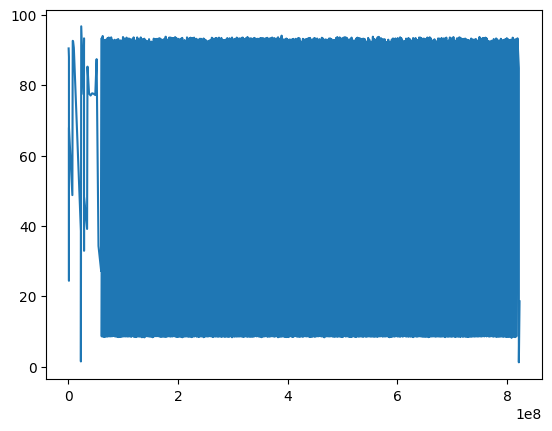

In [10]:
import matplotlib.pyplot as plt

plt.plot(metrics_df["start"], metrics_df[METRIC_MEMORY_THROUGHPUT_PERC], label="Memory Throughput")

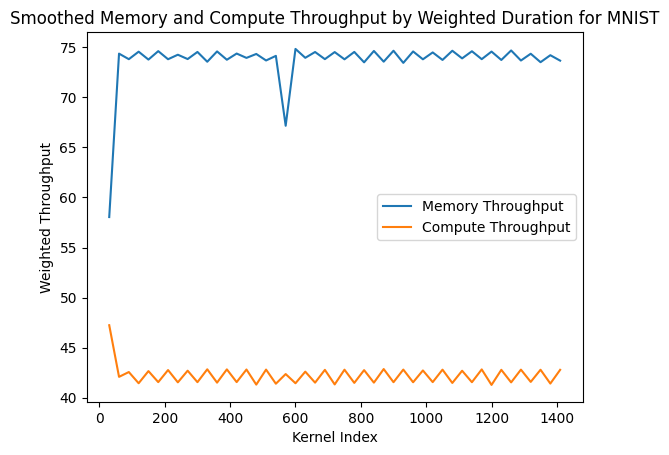

In [24]:
import matplotlib.pyplot as plt

# Calculate the weighted throughput
metrics_df['weighted_mem_throughput'] = metrics_df[METRIC_MEMORY_THROUGHPUT_PERC] * metrics_df[METRIC_DURATION]
metrics_df['weighted_compute_throughput'] = metrics_df[METRIC_COMPUTE_THROUGHPUT_PERC] * metrics_df[METRIC_DURATION]


# Compute the rolling weighted average
window_size = 30 # Adjust the window size as needed

rolling_avg_col = lambda metric_name: f'weighted_{metric_name}_rolling_avg'

def rolling_avg(metric_name, window_size):
    metrics_df[f'weighted_{metric_name}'] = metrics_df[metric_name] * metrics_df[METRIC_DURATION]
    metrics_df[rolling_avg_col(metric_name)] = metrics_df[f'weighted_{metric_name}'].rolling(window=window_size).sum() / metrics_df[METRIC_DURATION].rolling(window=window_size).sum()

rolling_avg(METRIC_MEMORY_THROUGHPUT_PERC, window_size)
rolling_avg(METRIC_COMPUTE_THROUGHPUT_PERC, window_size)

# Plot the smoothed graph
plt.plot(metrics_df[rolling_avg_col(METRIC_MEMORY_THROUGHPUT_PERC)][::window_size])
plt.plot(metrics_df[rolling_avg_col(METRIC_COMPUTE_THROUGHPUT_PERC)][::window_size])
plt.legend(['Memory Throughput', 'Compute Throughput'])
plt.xlabel('Kernel Index')
plt.ylabel('Weighted Throughput')
plt.title('Smoothed Memory and Compute Throughput by Weighted Duration for MNIST')
plt.savefig('weighted_throughput.png', dpi=300)
plt.show()


In [12]:
metrics_df.columns

Index(['gpu__compute_memory_throughput.avg.pct_of_peak_sustained_elapsed',
       'sm__throughput.avg.pct_of_peak_sustained_elapsed',
       'gpu__time_duration.max', 'time_stamp'],
      dtype='object')

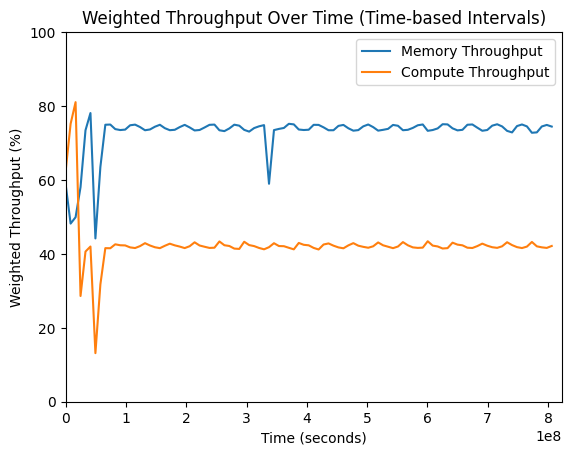

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'start_time' and 'end_time' columns exist in metrics_df to represent kernel times
n_intervals = 100
interval_length = total_duration / n_intervals

# Create the intervals (start and end times for each interval)
interval_edges = np.arange(0, total_duration, interval_length)

# Function to calculate weighted memory throughput for each interval
def compute_weighted_throughput_per_interval(metric_name, interval_edges):
    throughput_per_interval = []
    
    for i in range(len(interval_edges) - 1):
        interval_start = interval_edges[i]
        interval_end = interval_edges[i + 1]
        
        # For each interval, find the kernels that overlap with the interval
        mask = (metrics_df['start_time'] < interval_end) \
             & (metrics_df["end_time"] > interval_start)
        
        overlapping_kernels = metrics_df[mask]
        
        weighted_sum = 0
        duration_sum = 0
        
        for _, kernel in overlapping_kernels.iterrows():
            # Calculate the portion of the kernel's duration that overlaps with this interval
            overlap_start = max(kernel['start_time'], interval_start)
            overlap_end = min(kernel['end_time'], interval_end)
            overlap_duration = overlap_end - overlap_start
            
            # Add weighted memory throughput contribution
            weighted_sum += (kernel[metric_name] * overlap_duration)
            duration_sum += overlap_duration
        
        # Calculate the average for the interval
        throughput_avg = weighted_sum / duration_sum if duration_sum > 0 else 0
        throughput_per_interval.append(throughput_avg)
    
    return throughput_per_interval

# Compute the memory and compute throughput for each interval
memory_throughput_avg = compute_weighted_throughput_per_interval(METRIC_MEMORY_THROUGHPUT_PERC, interval_edges)
compute_throughput_avg = compute_weighted_throughput_per_interval(METRIC_COMPUTE_THROUGHPUT_PERC, interval_edges)

# Plot the results
plt.plot(interval_edges[:-1], memory_throughput_avg, label='Memory Throughput')
plt.plot(interval_edges[:-1], compute_throughput_avg, label='Compute Throughput')
plt.xlim(0, total_duration)
plt.ylim(0, 100)
plt.xlabel('Time (seconds)')
plt.ylabel('Weighted Throughput (%)')
plt.legend()
plt.title('Weighted Throughput Over Time (Time-based Intervals)')
plt.savefig('weighted_throughput_time_intervals.png', dpi=300)
plt.show()